In [443]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
from scipy.optimize import minimize
import math
warnings.filterwarnings("ignore")


# Bayesian optimization

In [338]:
# download data
cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            stratify = y,
                                        random_state = 42)

# scale and split data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1]:

# there is a function that will be optimized by
# surrogate function  
def black_box_function(
    black_box_model, 
    model_params,
    true_function, 
    X_train, X_test, 
    y_train, 
    y_test
):

    # We guess that calculating the black box model
    # is a long process. thats why we need a 
    # surrogate function 
    model = black_box_model()
    model.set_params(**model_params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # The true function evaluates our true model
    # (quolity functions: roc-auc, rmse etc.)
    black_box_score = true_function(y_test, y_pred)

    print(model_params, ':', black_box_score)

    return black_box_score


def ucb(mean_mu, lambda_param, sigma_std):
    return mean_mu + lambda_param * sigma_std

# The surrogate function depends on the surrogate 
# model
def aqusition_function(
    surrogate_model,
    X,
    lambda_param
):
    mean_mu, sigma_std = surrogate_model.predict(
        X, 
        return_std=True
    )
    ucb_vals = ucb(mean_mu, lambda_param, sigma_std)

    return ucb_vals

In [352]:
# Generate random int or float values
def get_random_values(params_grid, params_type, n_iter):

    epoche_param_grid = {x:[] for x in params_grid.keys()}

    for i in range(n_iter):
        for key, type in zip(params_grid, params_type):
            if type == "float":
                value = state.uniform(
                            params_grid[key][0], 
                            params_grid[key][1], 
                            size=1
                        )[0]
            
            elif type == "int":
                value = state.randint(
                            params_grid[key][0], 
                            params_grid[key][1], 
                            size=1
                        )[0]
            epoche_param_grid[key].append(value)

    return epoche_param_grid

def type_check(min_param, param_type):

    if param_type == 'int':
        return min_param.round()
    else:
        return min_param

In [451]:
true_function = accuracy_score
# true_function = roc_auc_score
acqusision_function = ucb

black_box_model = SVC
surrogate_model = GaussianProcessRegressor()

In [447]:
params_grid = {
    "C": [0.01, 10],
    "degree": [1, 5]
}
params_type = ['float', 'int']

In [452]:
# num of the true model eval
eval_nums = 30
# num epoches with random hyperparameters 
random_warm_epoches = 2

# lamda gets smaller on each iteration
# that solves exploration vs exploitation trade-off
lambda_param_func = lambda x, y: math.sqrt(math.log(y+1 - x))

# num of random values to evaluate surrogate model
n_iter = 500

# pipeline

In [453]:
params = []
targets = []
state = np.random.RandomState()
values_df = pd.DataFrame(
    index = range(1, eval_nums+1),
    columns =  params_grid.keys()
)

# we need a point with maximal std error (sigma)
# to evaluate on the next epoche. 
# thats why we need to get our aqusition_function with
# minus and minimize it.
to_minimize = lambda x:-aqusition_function(
        surrogate_model, 
        [x], 
        lambda_param=lambda_param
)

for epoche in range(1, eval_nums+1):

    lambda_param = lambda_param_func(epoche, eval_nums)

    print("epoche:", epoche, "lambda:", lambda_param)

    # get some epoches to warm up
    if epoche <= rand_epoches:

        # generate random hyperparameters
        values = get_random_values(params_grid, params_type, 1)

        # note down hyperparameters
        values = {x: y[-1] for x, y in zip(
                        values.keys(), 
                        values.values())}

        # evaluate black box function.
        # it will be a target for our surrogate
        # model
        targets.append(
                black_box_function(
                    black_box_model, 
                    values,
                    true_function, 
                    X_train_scaled, 
                    X_test_scaled, 
                    y_train, 
                    y_test 
                )  
        )

    else:

        # fit the model
        surrogate_model.fit(values_df.dropna().values, targets)
        # calculate surrogate function
        ucb_values = aqusition_function(
            surrogate_model,
            values_df.dropna().values,
            lambda_param=lambda_param
        )
        
        # get n_iter hyperparameters
        all_values = get_random_values(params_grid, params_type, n_iter)

        list_values = np.array([x for x in iter(all_values.values())])
        list_values_ = np.array([[x, y] for x,y in zip(list_values[0], list_values[1])])

        # predict values of the true function with random hyperparameters.
        # search for a point with maximal sigma.
        for x_try in list_values_:
                res = minimize(lambda x: to_minimize(x),
                            x_try,
                            bounds=[x for x in iter(params_grid.values())],
                            method="L-BFGS-B")
        
        # add this hyperparameters to df values.
        values = {x: type_check(y, z)
            for x,y,z in zip(params_grid.keys(), res.x, params_type)
        }
        
        # evaluate true function with these hyperparameters.
        targets.append(
                black_box_function(
                    black_box_model, 
                    values,
                    true_function, 
                    X_train_scaled, 
                    X_test_scaled, 
                    y_train, 
                    y_test 
                )  
        )

    values_df.loc[epoche] = values

values_df['target'] = targets        

epoche: 1 lambda: 1.8442335485675765
{'C': 4.245404529187648, 'degree': 2} : 0.9790209790209791
epoche: 2 lambda: 1.835019299622343
{'C': 0.6151680119529316, 'degree': 4} : 0.9790209790209791
epoche: 3 lambda: 1.8254326912201402
{'C': 3.1264881510312135, 'degree': 3.0} : 0.986013986013986
epoche: 4 lambda: 1.815443985917585
{'C': 1.653979657299839, 'degree': 3.0} : 0.986013986013986
epoche: 5 lambda: 1.8050198165176699
{'C': 0.2628675355010051, 'degree': 3.0} : 0.958041958041958
epoche: 6 lambda: 1.7941225779941015
{'C': 2.919109540009576, 'degree': 2.0} : 0.986013986013986
epoche: 7 lambda: 1.782709687623856
{'C': 1.1332645214445782, 'degree': 2.0} : 0.986013986013986
epoche: 8 lambda: 1.7707326777153998
{'C': 1.897477616235995, 'degree': 1.0} : 0.986013986013986
epoche: 9 lambda: 1.7581360736183977
{'C': 9.91418276172118, 'degree': 2.0} : 0.9790209790209791
epoche: 10 lambda: 1.7448559934055943
{'C': 0.39550760605193036, 'degree': 1.0} : 0.965034965034965
epoche: 11 lambda: 1.7308183

# Random search realisation

In [454]:
params_rand_search = []
targets_rand_search = []
state = np.random.RandomState()
values_df_rand_search = pd.DataFrame(
    index = range(1, eval_nums+1),
    columns =  params_grid.keys()
)

for epoche in range(1, eval_nums+1):

    print("epoche:", epoche)
    values = get_random_values(params_grid, params_type, 1)
    values = {x: y[-1] for x, y in zip(
                    values.keys(), 
                    values.values())}
    targets_rand_search.append(
            black_box_function(
                black_box_model, 
                values,
                true_function, 
                X_train_scaled, 
                X_test_scaled, 
                y_train, 
                y_test 
            )  
    )
    values_df_rand_search.loc[epoche] = values

values_df_rand_search['target'] = targets_rand_search

epoche: 1
{'C': 0.7520014047068717, 'degree': 4} : 0.9790209790209791
epoche: 2
{'C': 5.075254551461984, 'degree': 1} : 0.9790209790209791
epoche: 3
{'C': 9.453641076785363, 'degree': 3} : 0.9790209790209791
epoche: 4
{'C': 5.30075609446781, 'degree': 4} : 0.9790209790209791
epoche: 5
{'C': 2.4033798210854314, 'degree': 4} : 0.986013986013986
epoche: 6
{'C': 5.4726173913576535, 'degree': 3} : 0.9790209790209791
epoche: 7
{'C': 3.5538916864022037, 'degree': 2} : 0.986013986013986
epoche: 8
{'C': 6.814052310681068, 'degree': 4} : 0.9790209790209791
epoche: 9
{'C': 7.322015455809511, 'degree': 1} : 0.9790209790209791
epoche: 10
{'C': 6.480184250051789, 'degree': 3} : 0.9790209790209791
epoche: 11
{'C': 8.29054325545252, 'degree': 2} : 0.9790209790209791
epoche: 12
{'C': 6.170815288876071, 'degree': 2} : 0.9790209790209791
epoche: 13
{'C': 4.377597465997035, 'degree': 2} : 0.9790209790209791
epoche: 14
{'C': 7.930889471871195, 'degree': 1} : 0.9790209790209791
epoche: 15
{'C': 7.3727671401

# Results

bayesian 

In [455]:
values_df.loc[values_df.target == values_df.target.max()]

,C,degree,target
3,3.126488,3.0,0.986014
4,1.65398,3.0,0.986014
6,2.91911,2.0,0.986014
7,1.133265,2.0,0.986014
8,1.897478,1.0,0.986014
11,2.091614,4.0,0.986014
13,3.661798,1.0,0.986014
15,2.006516,2.0,0.986014
19,3.439384,4.0,0.986014
23,1.124236,1.0,0.986014


random search

In [456]:
values_df_rand_search.loc[values_df_rand_search.target == values_df_rand_search.target.max()]

,C,degree,target
5,2.40338,4.0,0.986014
7,3.553892,2.0,0.986014
16,3.007349,2.0,0.986014
25,0.716193,1.0,0.986014
27,3.11139,2.0,0.986014
28,2.82638,2.0,0.986014


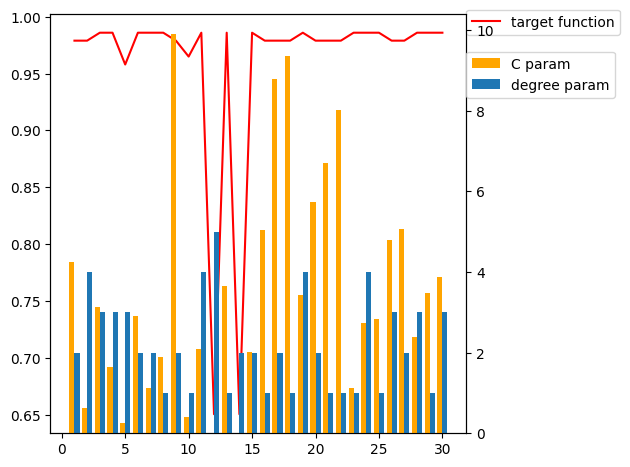

In [457]:
fig, ax = plt.subplots()
ax = plt.plot(values_df.index, values_df.target, color='red')

plt.legend(['target function'], loc=(1,0.95))
ax2 = plt.twinx()
rect1 = plt.bar(values_df.index-0.2, values_df['C'], width = 0.4, color='orange')
rect2 = plt.bar(values_df.index+0.2, values_df['degree'], width = 0.4)

plt.legend(['C param', 'degree param'],  loc=(1,0.8))
plt.tight_layout()
plt.show()

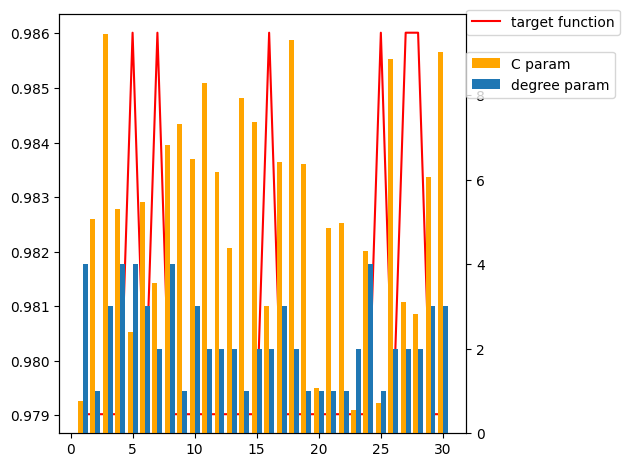

In [458]:
fig, ax = plt.subplots()
ax = plt.plot(values_df_rand_search.index, values_df_rand_search.target, color='red')

plt.legend(['target function'], loc=(1,0.95))
ax2 = plt.twinx()
rect1 = plt.bar(
    values_df_rand_search.index-0.2, values_df_rand_search['C'], width = 0.4, color='orange')
rect2 = plt.bar(
    values_df_rand_search.index+0.2, values_df_rand_search['degree'], width = 0.4)

plt.legend(['C param', 'degree param'],  loc=(1,0.8))
plt.tight_layout()
plt.show()

as you can see, random search got the maximal true function value. But it was a very simple example.